In [1]:
pip install pytrends


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [27]:
import pandas as pd
data = pd.read_csv('trends_covid_symptoms_test.csv')
data.head()

,date,covid test,covid symptoms
0,21/06/2020,12,44
1,28/06/2020,14,58
2,05/07/2020,16,61
3,12/07/2020,16,59
4,19/07/2020,16,48


In [28]:
data.describe

<bound method NDFrame.describe of            date  covid test  covid symptoms
0    21/06/2020          12              44
1    28/06/2020          14              58
2    05/07/2020          16              61
3    12/07/2020          16              59
4    19/07/2020          16              48
..          ...         ...             ...
257  25/05/2025           1               4
258  01/06/2025           1               4
259  08/06/2025           1               4
260  15/06/2025           1               4
261  22/06/2025           1               4

[262 rows x 3 columns]>

In [29]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True)

C:\Users\LO79RS\AppData\Local\Temp\ipykernel_22684\4283264224.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['date'] = pd.to_datetime(data['date'])


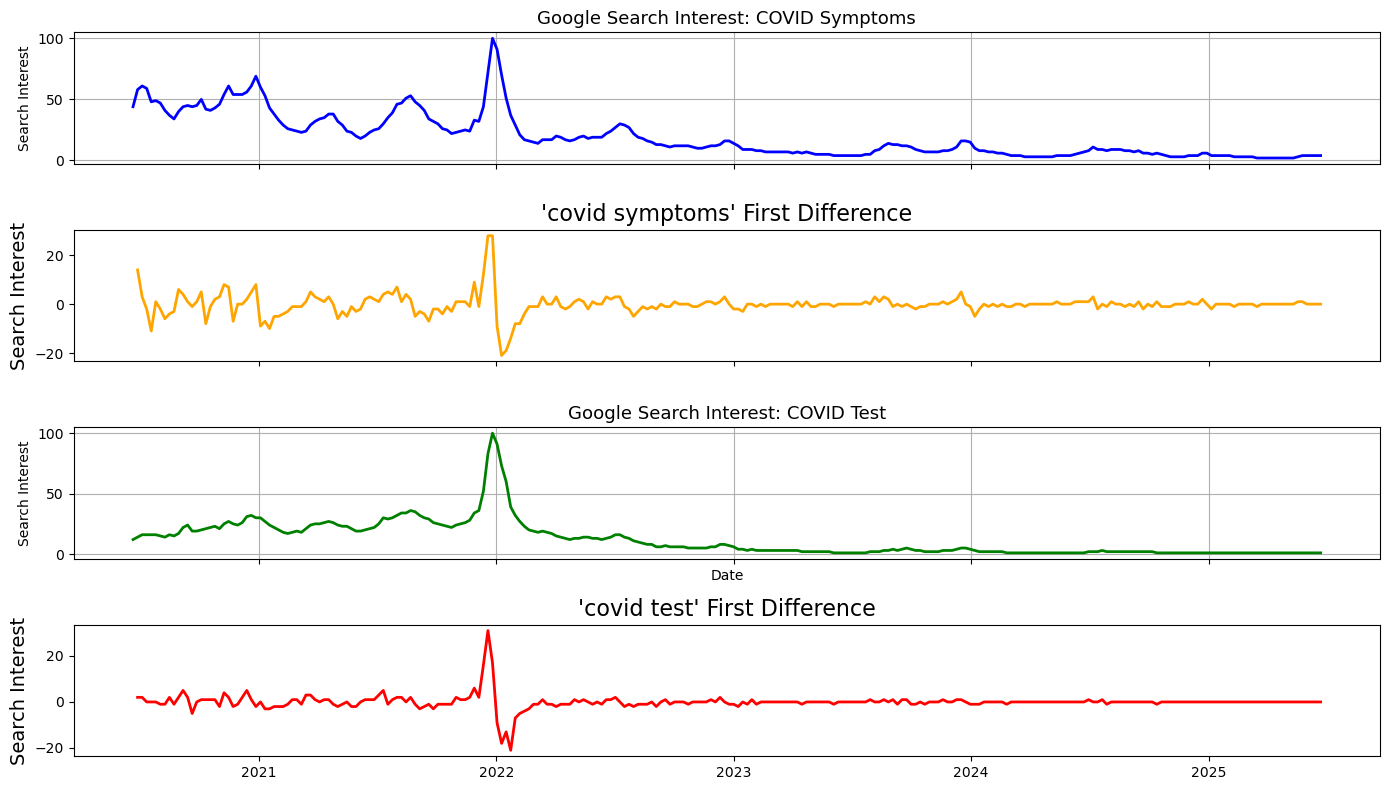

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(14, 8), sharex=True)

# Plot 1: covid symptoms
axs[0].plot(data.index, data['covid symptoms'], color='blue', linewidth=2)
axs[0].set_title('Google Search Interest: COVID Symptoms', fontsize=13)
axs[0].set_ylabel('Search Interest')
axs[0].grid(True)

# Plot 2: covid test
axs[2].plot(data.index, data['covid test'], color='green', linewidth=2)
axs[2].set_title('Google Search Interest: COVID Test', fontsize=13)
axs[2].set_ylabel('Search Interest')
axs[2].set_xlabel('Date')
axs[2].grid(True)

# First difference graphs
test_diff = data['covid test'].diff()  
symptoms_diff =data['covid symptoms'].diff()

axs[1].plot(data.index, symptoms_diff, linewidth=2, color='orange')
axs[1].set_title("'covid symptoms' First Difference", fontsize=16)
axs[1].set_ylabel('Search Interest', fontsize=14)

axs[3].plot(data.index, test_diff, linewidth=2, color='red')
axs[3].set_title("'covid test' First Difference", fontsize=16)
axs[3].set_ylabel('Search Interest', fontsize=14)


plt.tight_layout()
plt.show()

##### 1. ADF Test for stationarity

In [31]:
from statsmodels.tsa.stattools import adfuller

In [32]:
def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}:")
    print(f" Test Statistic : {result[0]:.4f}")
    print(f" p-value : {result[1]:.4f}")
    print(f" Critical Values:")
    for key, value in result[4].items():
        print(f" {key}: {value:.4f}")
    print(" =>", "Stationary" if result[1] < 0.05 else "Non-stationary", "\n")

In [33]:
adf_test(data['covid symptoms'], 'covid symptomps')
adf_test(data['covid test'], 'covid test')

ADF Test for covid symptomps:
 Test Statistic : -1.5619
 p-value : 0.5027
 Critical Values:
 1%: -3.4570
 5%: -2.8733
 10%: -2.5730
 => Non-stationary 

ADF Test for covid test:
 Test Statistic : -1.8730
 p-value : 0.3449
 Critical Values:
 1%: -3.4565
 5%: -2.8730
 10%: -2.5729
 => Non-stationary 



In [76]:
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
def adf_test(series, max_aug=10, version='n'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        
        for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            cv1 = -2.567; cv5 = -1.941; cv10 = -1.616 
        elif version == 'c':
            cv1 = -3.434; cv5 = -2.863; cv10 = -2.568 
        elif version == 't': # critical values for version with constant and (deterministic) trend component
            cv1 = -3.963; cv5 = -3.413; cv10 = -3.128 
            

        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

        results.append([i, ts, cv1, cv5, cv10, bg_pvalue5, bg_pvalue10, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
    
    return results_df

In [77]:
adf_test(data['covid symptoms'], max_aug=10)


,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-1.847794,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-3.233137,-2.567,-1.941,-1.616,0.0071,0.0066,0.0040
2,2,-2.589278,-2.567,-1.941,-1.616,0.3490,0.1083,0.0164
3,3,-2.400541,-2.567,-1.941,-1.616,0.0005,0.0018,0.0002
4,4,-2.165708,-2.567,-1.941,-1.616,0.0063,0.0029,0.0010
5,5,-2.262135,-2.567,-1.941,-1.616,0.0144,0.0105,0.0247
6,6,-2.090138,-2.567,-1.941,-1.616,0.0007,0.0009,0.0035
7,7,-1.786266,-2.567,-1.941,-1.616,0.0440,0.0872,0.1040
8,8,-1.836206,-2.567,-1.941,-1.616,0.0187,0.0482,0.0712
9,9,-1.684149,-2.567,-1.941,-1.616,0.0437,0.0050,0.0030


In [78]:
adf_test(data['covid test'], max_aug=10)

,number of augmentations,ADF test statistic,ADF critival value (1%),ADF critival value (5%),ADF critival value (10%),BG test (5 lags) (p-value),BG test (10 lags) (p-value),BG test (15 lags) (p-value)
0,0,-1.528888,-2.567,-1.941,-1.616,0.0000,0.0000,0.0000
1,1,-3.209195,-2.567,-1.941,-1.616,0.0000,0.0000,0.0001
2,2,-2.299845,-2.567,-1.941,-1.616,0.0060,0.0336,0.0967
3,3,-2.321613,-2.567,-1.941,-1.616,0.0095,0.0406,0.1077
4,4,-2.007480,-2.567,-1.941,-1.616,0.0262,0.0853,0.2642
5,5,-1.792230,-2.567,-1.941,-1.616,0.0494,0.1407,0.2415
6,6,-1.947276,-2.567,-1.941,-1.616,0.0608,0.2355,0.2983
7,7,-1.694533,-2.567,-1.941,-1.616,0.3349,0.5010,0.5063
8,8,-1.579415,-2.567,-1.941,-1.616,0.3079,0.4248,0.4382
9,9,-1.516459,-2.567,-1.941,-1.616,0.1835,0.2306,0.3873


### 1. Stationarity Analysis – ADF Test Results

We performed the Augmented Dickey-Fuller (ADF) test on both time series:
**`covid symptoms`** and **`covid test`**, using 0 to 9 augmentations.

---

 ADF Test for `covid symptoms`

- ADF statistic at augmentation 1: **-3.23**
- 5% critical value: **-1.941**
- p-value: **0.0001**
- The series becomes **stationary** at **augmentation 1** (lag = 1), as the ADF statistic is lower than the 5% critical value and the p-value is < 0.05.

> Breusch-Godfrey (BG) tests at this lag show:
> - BG p-value (5 lags): 0.0071 
> - BG p-value (10 lags): 0.0066 
> - BG p-value (15 lags): 0.0040 
> → This confirms residuals are not autocorrelated, so ADF result is reliable.


 ADF Test for `covid test`

- ADF statistic at augmentation 1: **-3.209**
- 5% critical value: **-1.941**
- p-value: **0.0000**
- The series becomes **stationary** at **augmentation 1** (lag = 1), similar to `covid symptoms`.

> BG test results:
> - BG p-value (5 lags): 0.0000 
> - BG p-value (10 lags): 0.0000 
> - BG p-value (15 lags): 0.0000 
> → Residuals are also clean, supporting the validity of the ADF result.

---
Both series are non-stationary in levels but become stationary after **first-order differencing with 1 augmentation (lag = 1)**.

##### 2. Granger Causality Test

In [79]:
data_diff = data.diff().dropna()

In [81]:
from statsmodels.tsa.stattools import grangercausalitytests

# Symptoms → Test
print("Granger Causality: covid symptoms → covid test")
grangercausalitytests(data_diff[['covid test', 'covid symptoms']], maxlag=8, verbose=True)

# Test → Symptoms
print("\nGranger Causality: covid test → covid symptoms")
grangercausalitytests(data_diff[['covid symptoms', 'covid test']], maxlag=8, verbose=True)

Granger Causality: covid symptoms → covid test

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5821  , p=0.4462  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=0.5889  , p=0.4429  , df=1
likelihood ratio test: chi2=0.5882  , p=0.4431  , df=1
parameter F test:         F=0.5821  , p=0.4462  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8597  , p=0.4245  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=1.7533  , p=0.4162  , df=2
likelihood ratio test: chi2=1.7474  , p=0.4174  , df=2
parameter F test:         F=0.8597  , p=0.4245  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6802  , p=0.5649  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=2.0974  , p=0.5524  , df=3
likelihood ratio test: chi2=2.0889  , p=0.5542  , df=3
parameter F test:         F=0.6802  , p=0.5649  , df_denom=251, df_num=3

Granger Causality
number of lags (no zero) 4
s

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{1: ({'ssr_ftest': (66.01996465484426, 1.8856474211003444e-14, 257.0, 1),
   'ssr_chi2test': (66.79062572085411, 3.019305001450343e-16, 1),
   'lrtest': (59.44589208848947, 1.2570321460485524e-14, 1),
   'params_ftest': (66.01996465484426, 1.8856474211003444e-14, 257.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (45.875365003858114, 9.794168737348166e-18, 254.0, 2),
   'ssr_chi2test': (93.5568467401516, 4.834915165321293e-21, 2),
   'lrtest': (79.87140805872514, 4.530478869118966e-18, 2),
   'params_ftest': (45.87536500385821, 9.794168737347681e-18, 254.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (29.547175804222835, 2.1483493407281417e-16, 251.0, 3),
   'ssr_chi2test': (91.11360188234453, 1.2628588859010278e-19, 3),
   'lrtest': (78.02895011441888, 8.123800990355319e-17, 3),
   'params_ftest': (29.54717580422278, 2.1483493407282654e-16, 251.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0

### 3. VAR (Vector Autoregression) Model

In [ ]:
from statsmodels.tsa.api import VAR

model = VAR(data_diff[['covid symptoms', 'covid test']])

# Evaluation of lag order using AIC, BIC, FPE and HQIC
lag_results = model.select_order(maxlags=10)

print(lag_results.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        4.127       4.155       62.00       4.138
1        3.501       3.585       33.15       3.535
2        3.362      3.502*       28.83      3.418*
3        3.386       3.582       29.54       3.465
4        3.356       3.609       28.67       3.457
5        3.360       3.669       28.80       3.485
6        3.384       3.749       29.49       3.531
7        3.347       3.769       28.44       3.517
8        3.329       3.807       27.94       3.522
9        3.344       3.877       28.34       3.558
10      3.310*       3.900      27.40*       3.547
--------------------------------------------------


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In order to select the optimal lag length for the VAR model, we evaluated four different information criteria: AIC, BIC, FPE, and HQIC. The results were somewhat divergent: AIC and FPE suggested a lag length of 10, while BIC and HQIC recommended a lag length of 2.
Since AIC and FPE are more suitable when the goal is accurate forecasting, and BIC and HQIC favor more parsimonious models, we will model both VAR(2) and VAR(10) and we will decide which one gives better results in the end.

In [96]:
n_total = len(data_diff)
n_train = int(n_total * 0.80)
n_test = n_total - n_train

train = data_diff.iloc[:n_train]
test = data_diff.iloc[n_train:]

#### VAR(2)

In [100]:
from statsmodels.tsa.api import VAR
model = VAR(train)
var2_model = model.fit(2)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


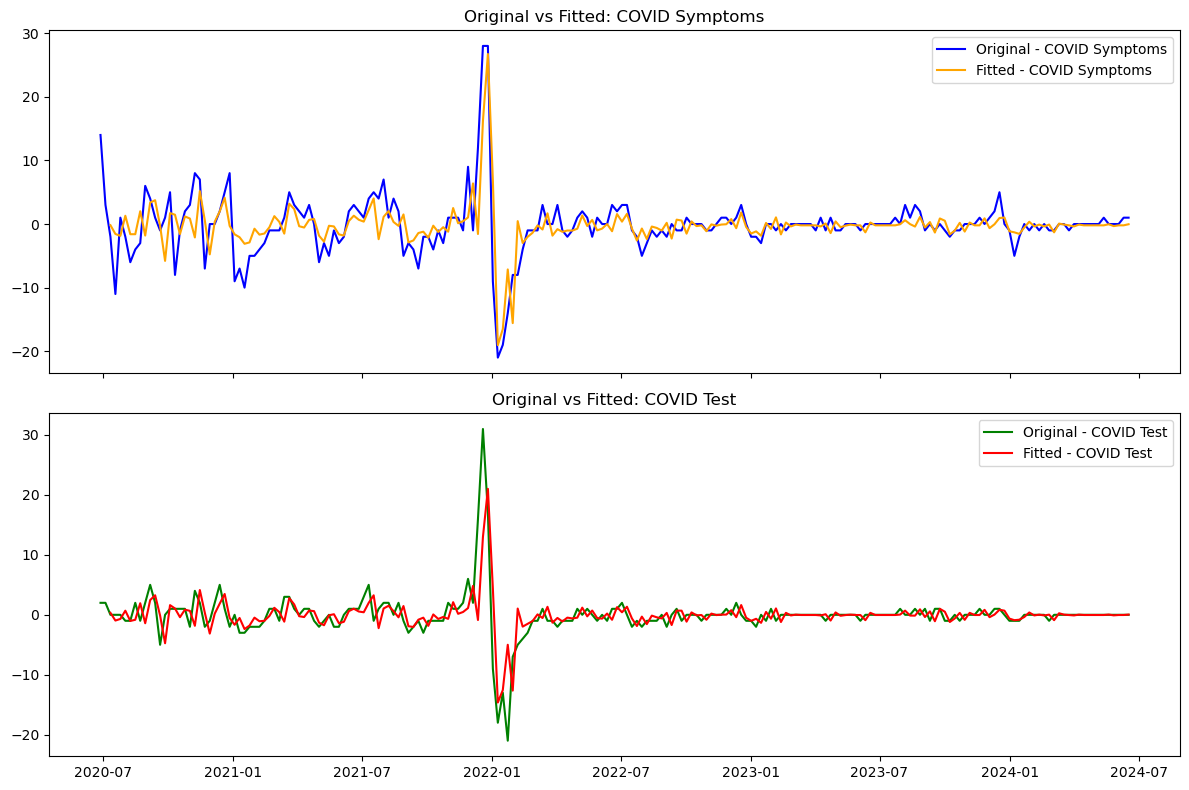

In [101]:
import matplotlib.pyplot as plt

fv2 = var2_model.fittedvalues

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Original vs Fitted: COVID Symptoms
axes[0].plot(train['covid symptoms'], label='Original - COVID Symptoms', color='blue')
axes[0].plot(fv2['covid symptoms'], label='Fitted - COVID Symptoms', color='orange')
axes[0].set_title('Original vs Fitted: COVID Symptoms')
axes[0].legend()

# Original vs Fitted: COVID Test
axes[1].plot(train['covid test'], label='Original - COVID Test', color='green')
axes[1].plot(fv2['covid test'], label='Fitted - COVID Test', color='red')
axes[1].set_title('Original vs Fitted: COVID Test')
axes[1].legend()

plt.tight_layout()
plt.show()

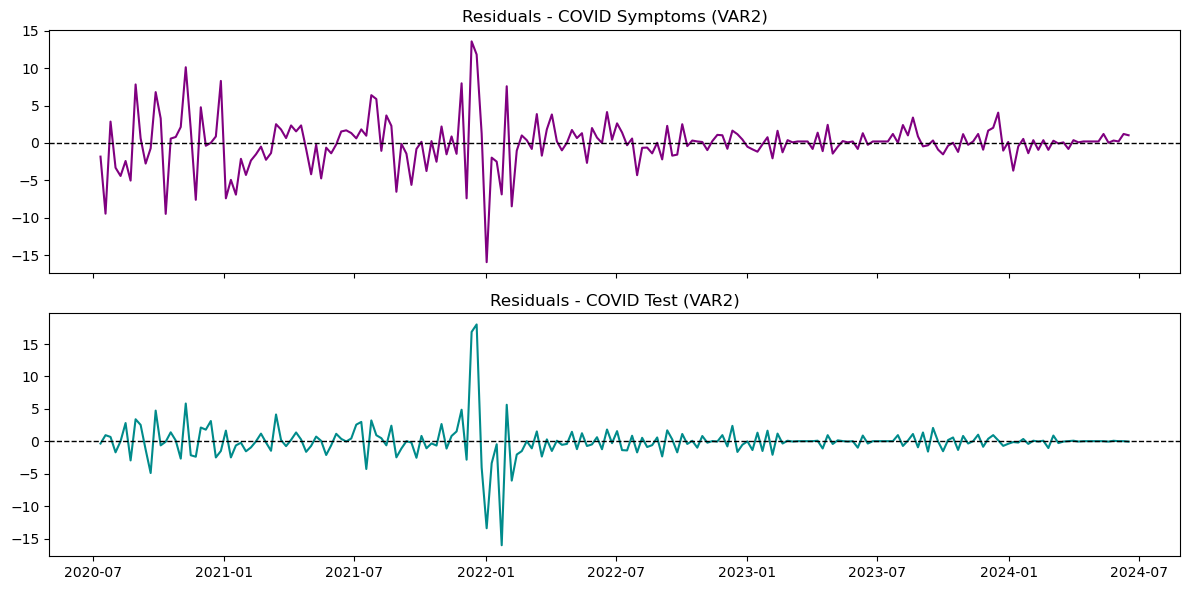

In [103]:
# VAR(2) model residuals
residuals_var2 = var2_model.resid

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot residuals - COVID Symptoms
axes[0].plot(residuals_var2['covid symptoms'], color='purple')
axes[0].set_title('Residuals - COVID Symptoms (VAR2)')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)

# Plot residuals - COVID Test
axes[1].plot(residuals_var2['covid test'], color='darkcyan')
axes[1].set_title('Residuals - COVID Test (VAR2)')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

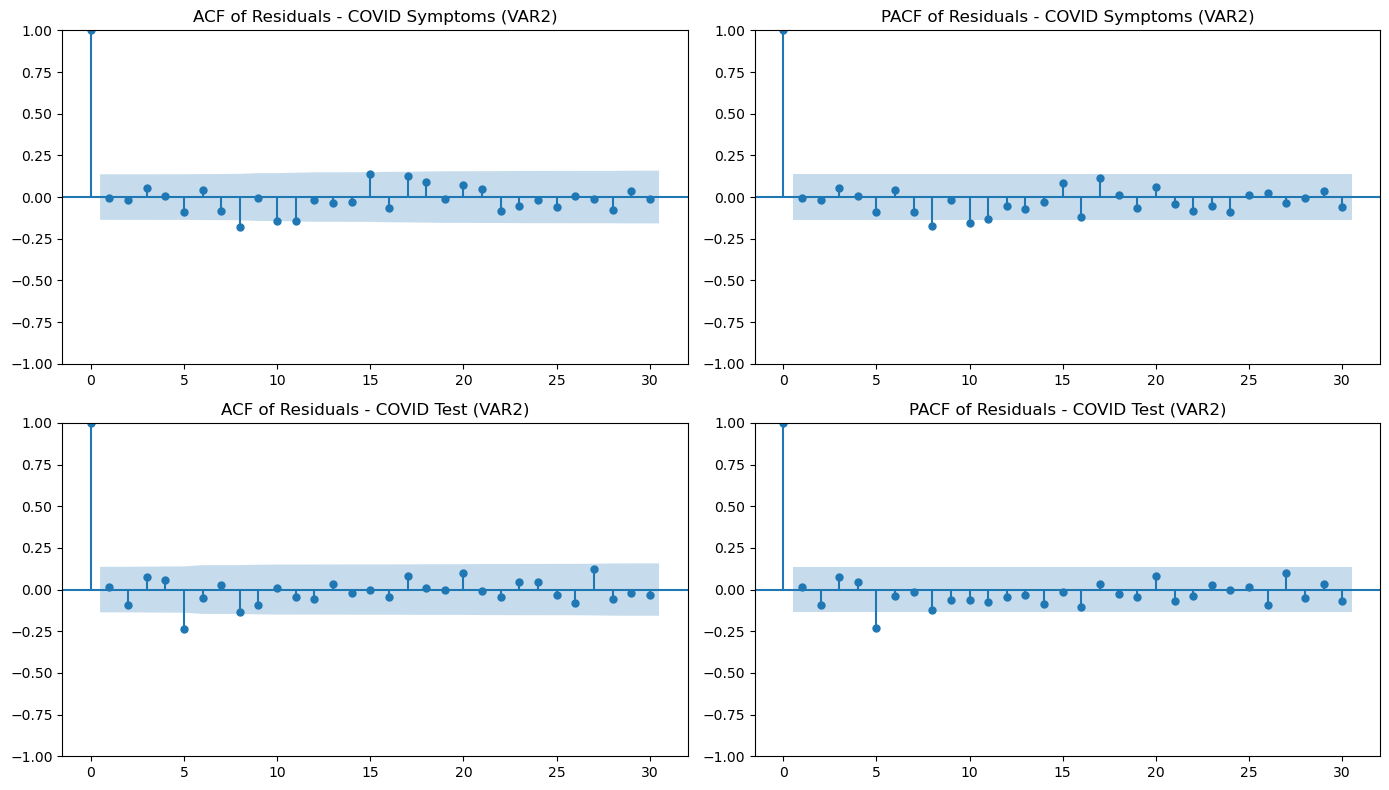

In [105]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# COVID Symptoms - ACF
plot_acf(residuals_var2['covid symptoms'], lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF of Residuals - COVID Symptoms (VAR2)')

# COVID Symptoms - PACF
plot_pacf(residuals_var2['covid symptoms'], lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF of Residuals - COVID Symptoms (VAR2)')

# COVID Test - ACF
plot_acf(residuals_var2['covid test'], lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals - COVID Test (VAR2)')

# COVID Test - PACF
plot_pacf(residuals_var2['covid test'], lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Residuals - COVID Test (VAR2)')

plt.tight_layout()
plt.show()

In [ ]:
# Portmanteau test (H0: Residuals are white noise)
whiteness_test = var2_model.test_whiteness(nlags=10)
print("Portmanteau Test (White Noise):")
print(whiteness_test.summary())

Portmanteau Test (White Noise):
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         58.73          46.19   0.003 32
----------------------------------------


In [109]:
from statsmodels.stats.diagnostic import acorr_lm

symptoms_resid = var2_model.resid['covid symptoms']

test_resid = var2_model.resid['covid test']

print("Breusch-Godfrey LM Test for COVID Symptoms Residuals")
lm_symptoms = acorr_lm(symptoms_resid, nlags=10)
print(f"LM stat: {lm_symptoms[0]:.4f}, p-value: {lm_symptoms[1]:.4f}")

print("\nBreusch-Godfrey LM Test for COVID Test Residuals")
lm_test = acorr_lm(test_resid, nlags=10)
print(f"LM stat: {lm_test[0]:.4f}, p-value: {lm_test[1]:.4f}")


Breusch-Godfrey LM Test for COVID Symptoms Residuals
LM stat: 19.4820, p-value: 0.0346

Breusch-Godfrey LM Test for COVID Test Residuals
LM stat: 17.9154, p-value: 0.0564


#### VAR(10)

In [110]:
var10_model = model.fit(10)


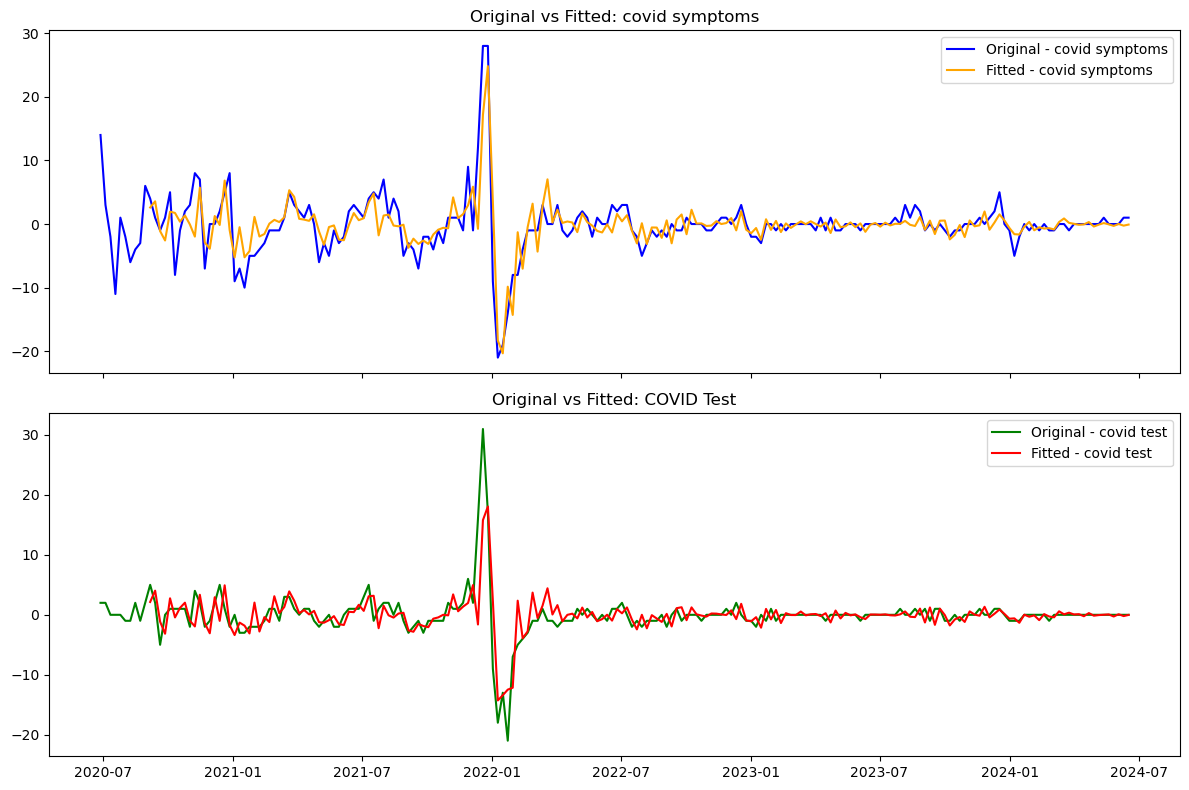

In [111]:
fv10 = var10_model.fittedvalues

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Original vs Fitted: COVID Symptoms
axes[0].plot(train['covid symptoms'], label='Original - covid symptoms', color='blue')
axes[0].plot(fv10['covid symptoms'], label='Fitted - covid symptoms', color='orange')
axes[0].set_title('Original vs Fitted: covid symptoms')
axes[0].legend()

# Original vs Fitted: COVID Test
axes[1].plot(train['covid test'], label='Original - covid test', color='green')
axes[1].plot(fv10['covid test'], label='Fitted - covid test', color='red')
axes[1].set_title('Original vs Fitted: COVID Test')
axes[1].legend()

plt.tight_layout()
plt.show()

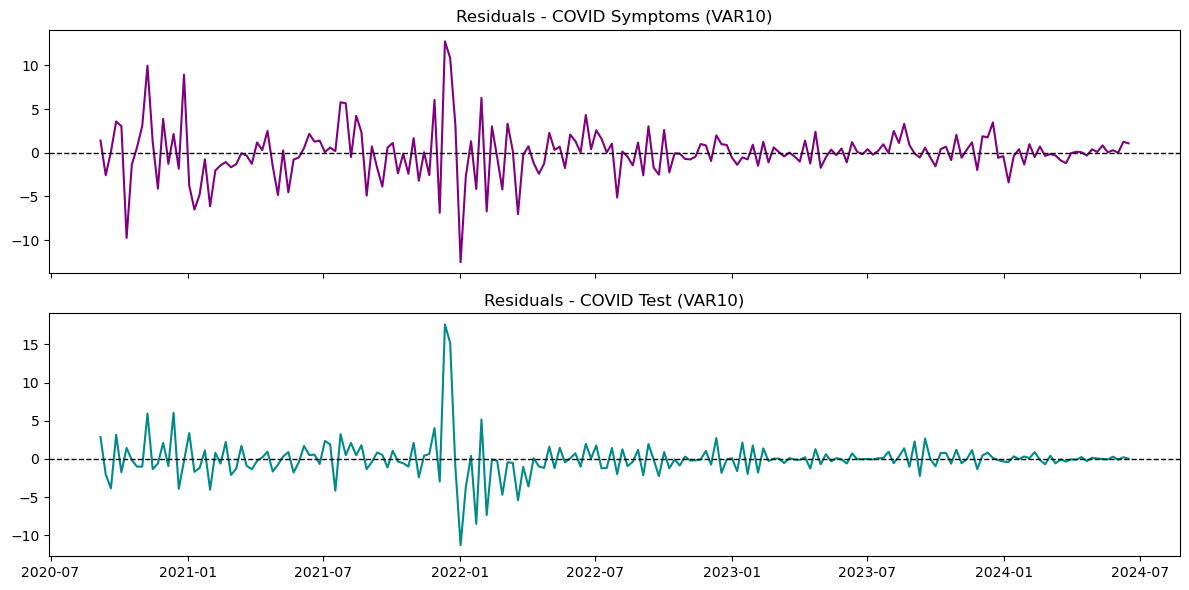

In [112]:
# VAR(10) model residuals
residuals_var10 = var10_model.resid

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot residuals - COVID Symptoms
axes[0].plot(residuals_var10['covid symptoms'], color='purple')
axes[0].set_title('Residuals - COVID Symptoms (VAR10)')
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1)

# Plot residuals - COVID Test
axes[1].plot(residuals_var10['covid test'], color='darkcyan')
axes[1].set_title('Residuals - COVID Test (VAR10)')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

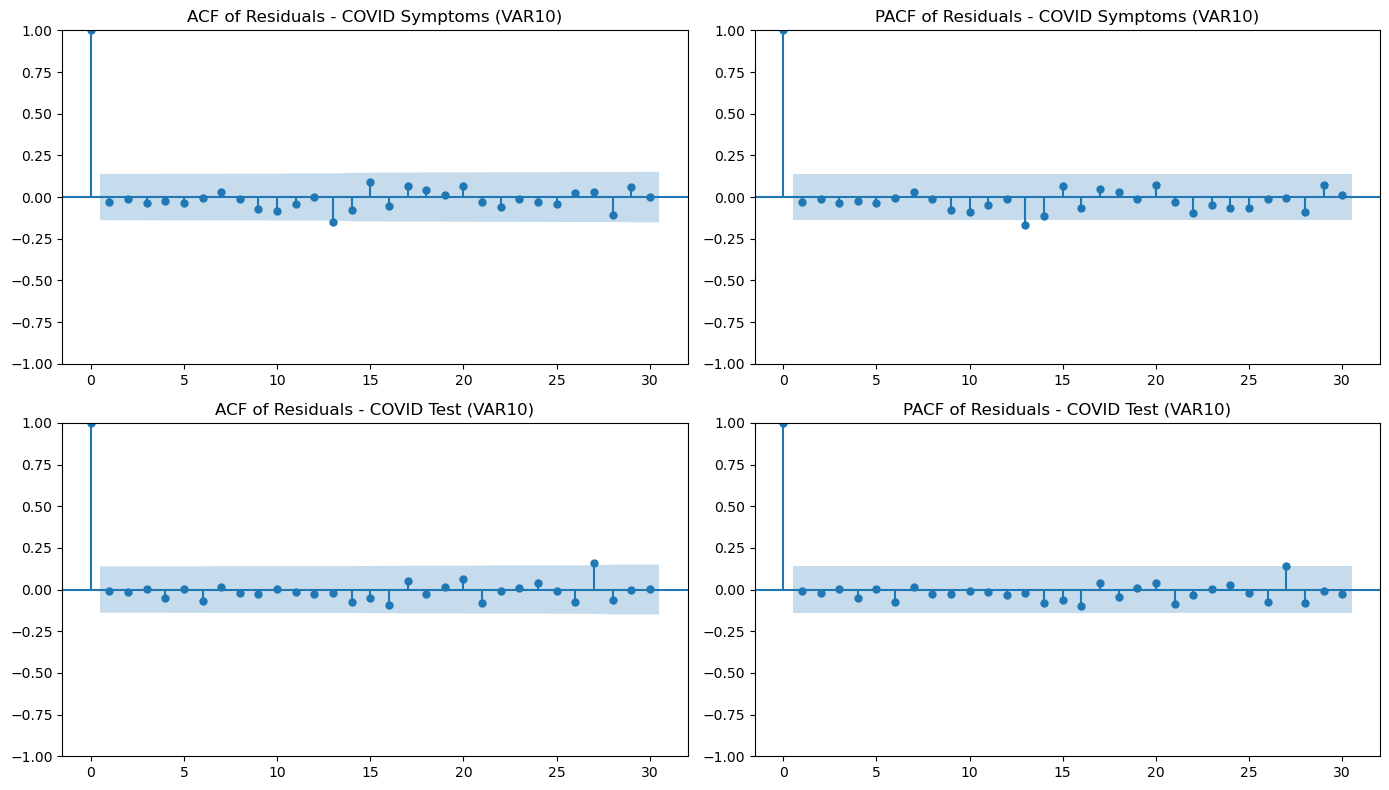

In [113]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# COVID Symptoms - ACF
plot_acf(residuals_var10['covid symptoms'], lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF of Residuals - COVID Symptoms (VAR10)')

# COVID Symptoms - PACF
plot_pacf(residuals_var10['covid symptoms'], lags=30, ax=axes[0, 1])
axes[0, 1].set_title('PACF of Residuals - COVID Symptoms (VAR10)')

# COVID Test - ACF
plot_acf(residuals_var10['covid test'], lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals - COVID Test (VAR10)')

# COVID Test - PACF
plot_pacf(residuals_var10['covid test'], lags=30, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Residuals - COVID Test (VAR10)')

plt.tight_layout()
plt.show()

In [115]:
# Portmanteau test (H0: Residuals are white noise)
whiteness_test10 = var10_model.test_whiteness(nlags=12)
print("Portmanteau Test (White Noise):")
print(whiteness_test.summary())

Portmanteau Test (White Noise):
Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 10 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         58.73          46.19   0.003 32
----------------------------------------


In [117]:
from statsmodels.stats.diagnostic import acorr_lm

symptoms_resid10 = var10_model.resid['covid symptoms']

test_resid10 = var10_model.resid['covid test']

print("Breusch-Godfrey LM Test for COVID Symptoms Residuals")
lm_symptoms10 = acorr_lm(symptoms_resid10, nlags=12)
print(f"LM stat: {lm_symptoms[0]:.4f}, p-value: {lm_symptoms[1]:.4f}")

print("\nBreusch-Godfrey LM Test for COVID Test Residuals")
lm_test10 = acorr_lm(test_resid10, nlags=12)
print(f"LM stat: {lm_test[0]:.4f}, p-value: {lm_test[1]:.4f}")


Breusch-Godfrey LM Test for COVID Symptoms Residuals
LM stat: 19.4820, p-value: 0.0346

Breusch-Godfrey LM Test for COVID Test Residuals
LM stat: 17.9154, p-value: 0.0564


Residual Diagnostics and Model Evaluation: VAR(2) vs. VAR(10)


To evaluate the adequacy of the VAR(2) and VAR(10) models, both information criteria and residual diagnostic tests were considered. The analysis includes model selection justification, graphical residual checks, and formal statistical testing.

1. Model Selection via Information Criteria


The initial choice of lag lengths was guided by multiple information criteria, such as the Akaike Information Criterion (AIC), the Schwarz Criterion (SC), and the Hannan–Quinn Criterion (HQ).

VAR(2) was selected as a lower-lag benchmark.

VAR(10) was chosen based on the fact that it minimized AIC and provided better performance in terms of model fit and forecast ability.

This justifies the inclusion of a higher-order model in the analysis and comparison.

2. Original vs. Fitted Series


In both models, the fitted values closely follow the original series, especially outside the volatile spike observed in early 2022. The VAR(10) model shows slightly better alignment with the observed series, indicating improved in-sample fit due to the longer memory structure.

3. Residual Plots
VAR(2) residuals show slightly higher variance and more irregular behavior.

VAR(10) residuals are visibly smoother and more stable, suggesting better error structure and model specification.

4. ACF and PACF of Residuals
VAR(2): ACF and PACF plots show notable spikes, especially at lower lags, indicating the presence of autocorrelation.

VAR(10): Most autocorrelations remain within the 95% confidence bounds, supporting the assumption of white noise residuals.

5. Portmanteau Test for Whiteness


Both models were subjected to the Portmanteau test with 10–12 lags:

Test Statistic = 58.73, Critical Value = 46.19, p-value = 0.003

→ For both models, the null hypothesis of residuals being white noise is rejected at the 5% level. This suggests the presence of autocorrelation that may not be fully captured even in VAR(10), despite better visual diagnostics.

6. Breusch-Godfrey LM Test


Conducted separately on each residual series:

VAR(2):

COVID Symptoms: LM stat = 19.48, p = 0.0346 → Significant autocorrelation

COVID Test: LM stat = 17.92, p = 0.0564 → Marginally insignificant

VAR(10):

COVID Symptoms: LM stat = 19.48, p = 0.0346 → Autocorrelation still present

COVID Test: LM stat = 17.92, p = 0.0564 → No significant autocorrelation



These results confirm that although the residual structure improves in VAR(10), the COVID symptoms residuals still display some autocorrelation, while the COVID test residuals are closer to white noise.



Although neither model fully satisfies all diagnostic checks, the VAR(10) model outperforms VAR(2) across most criteria:

It has lower AIC and better visual fit.

Residuals are smoother and show reduced autocorrelation.

Formal diagnostics suggest better (though not perfect) residual behavior.



Therefore, VAR(10) is a better-specified model for this dataset and will be used for further analyses such as forecasting and impulse response evaluation.



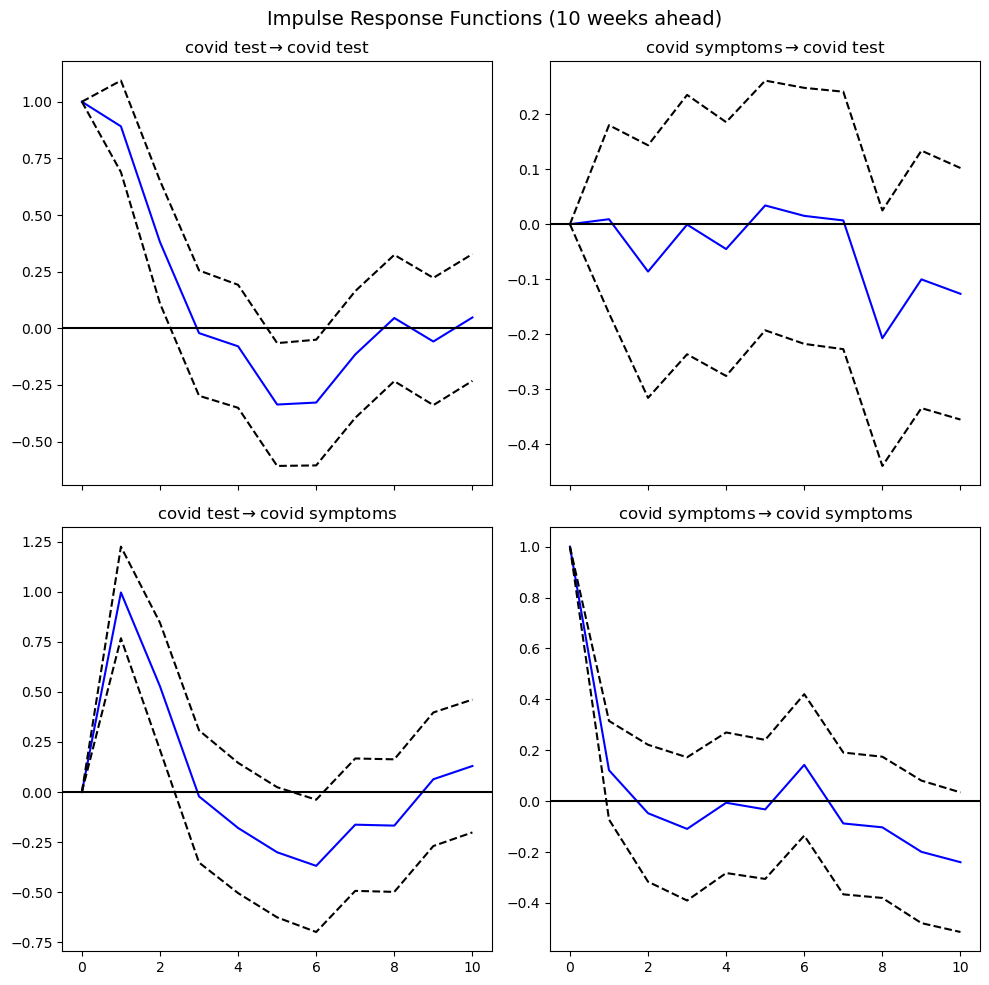

In [118]:
# Calculate IRF from fitted VAR(1) model
irf_var10 = var10_model.irf(10) # 10 steps ahead

irf_var10.plot(orth=False)
plt.suptitle("Impulse Response Functions (10 weeks ahead)", fontsize=14)
plt.tight_layout()
plt.show()

A shock to 'covid test' leads to a short-term increase in symptom-related searches, peaking early and fading by week 6–7.

A shock to 'covid symptoms' causes a mild increase in testing, peaking around week 3.

Both variables show strong self-responses that quickly decay.


The results confirm short-term dynamic interactions and validate the use of a VAR model.

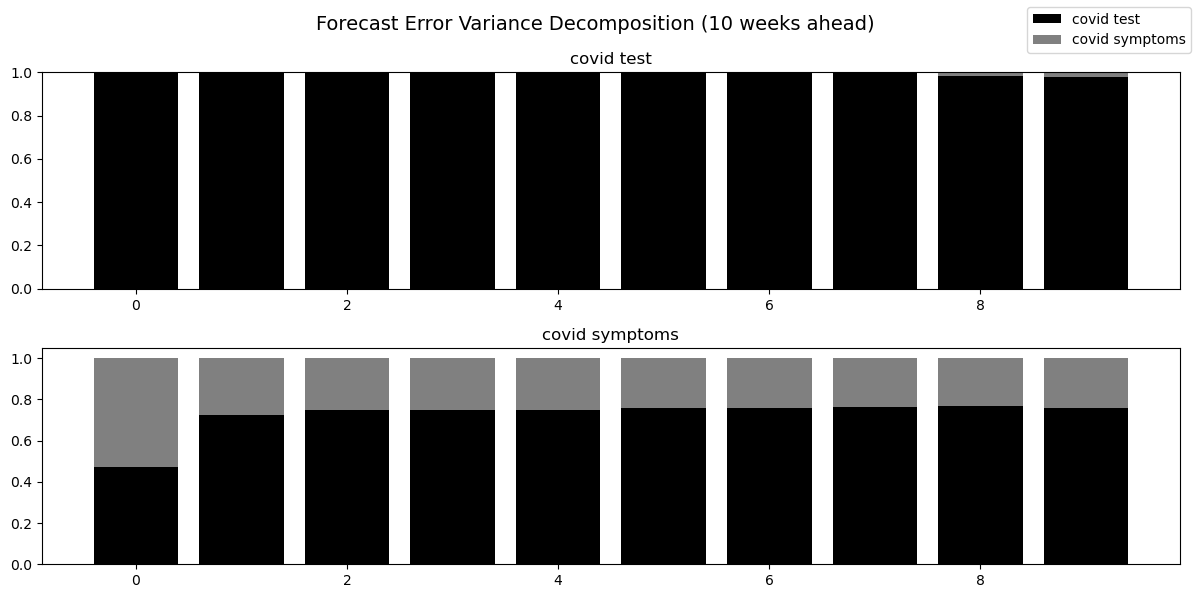

In [119]:
# Calculate FEVD from fitted VAR(1) model
fevd_var10 = var10_model.fevd(10) # 10 steps ahead

# Plot FEVD
fevd_var10.plot(figsize=(12,6))
plt.suptitle("Forecast Error Variance Decomposition (10 weeks ahead)", fontsize=14)
plt.tight_layout()
plt.show()

FEVD plot shows that

'covid test' variance is almost entirely explained by its own shocks, indicating strong autoregressive behavior.

'covid symptoms' variance is partially driven by covid test shocks, especially in early periods (~50%), suggesting interdependence.

Variance shares stabilize after ~4 weeks, indicating short-term dynamics and system convergence.

In [123]:
forecast_steps = len(test)
forecast_input = train[['covid symptoms', 'covid test']].values[-var10_model.k_ar:]
forecast_var10 = var10_model.forecast(y=forecast_input, steps=len(test))

forecast_index = test.index
forecast_df_var10 = pd.DataFrame(
    forecast_var10,
    index=forecast_index,
    columns=['covid symptoms', 'covid test']
)


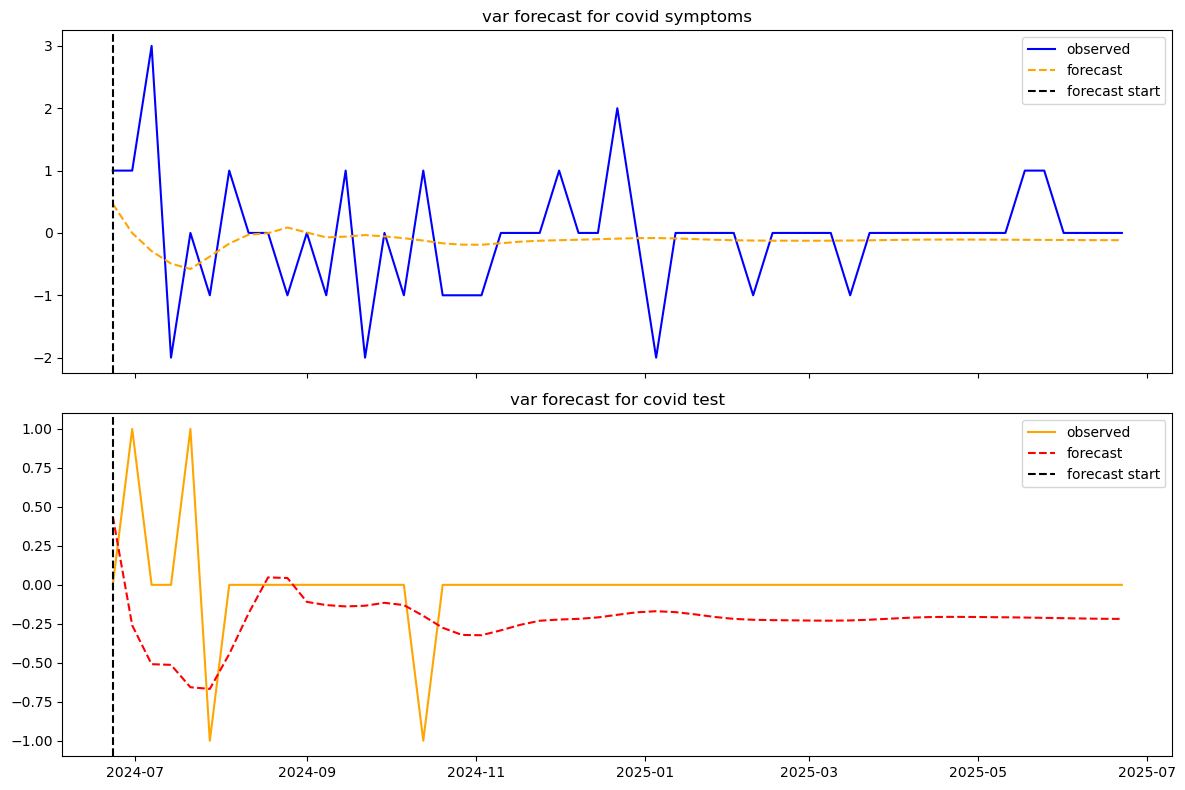

In [124]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# covid symptoms
axes[0].plot(test['covid symptoms'], label='observed', color='blue')
axes[0].plot(forecast_df_var10['covid symptoms'], label='forecast', color='orange', linestyle='--')
axes[0].set_title('var forecast for covid symptoms')
axes[0].axvline(x=forecast_df_var10.index[0], color='black', linestyle='--', label='forecast start')
axes[0].legend()

# covid test
axes[1].plot(test['covid test'], label='observed', color='orange')
axes[1].plot(forecast_df_var10['covid test'], label='forecast', color='red', linestyle='--')
axes[1].set_title('var forecast for covid test')
axes[1].axvline(x=forecast_df_var10.index[0], color='black', linestyle='--', label='forecast start')
axes[1].legend()

plt.tight_layout()
plt.show()

The VAR(10) model’s out-of-sample forecast shows reasonably stable predictions, especially for covid test.

For covid symptoms, the model captures the trend but misses some short-term volatility.

For covid test, the forecast converges quickly to a steady level, reflecting the model’s confidence in the past dynamics.

The forecast start is clearly marked, and visual inspection suggests that the model performs better for covid test than for covid symptoms in terms of forecast stability and bias.

In [113]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define MAPE and sMAPE functions
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# True test values
true_symptoms_var = test_data['covid symptoms'].values
true_test_var = test_data['covid test'].values

forecast_symptoms_var = forecast_df_var['covid symptoms'].values
forecast_test_var = forecast_df_var['covid test'].values

# Calculate metrics for covid symptoms
rmse_symptoms_var = np.sqrt(mean_squared_error(true_symptoms_var, forecast_symptoms_var))
mae_symptoms_var = mean_absolute_error(true_symptoms_var, forecast_symptoms_var)
mape_symptoms_var = mape(true_symptoms_var, forecast_symptoms_var)
smape_symptoms_var = smape(true_symptoms_var, forecast_symptoms_var)

# Calculate metrics for covid test
rmse_test_var = np.sqrt(mean_squared_error(true_test_var, forecast_test_var))
mae_test_var = mean_absolute_error(true_test_var, forecast_test_var)
mape_test_var = mape(true_test_var, forecast_test_var)
smape_test_var = smape(true_test_var, forecast_test_var)

import pandas as pd

metrics_var = pd.DataFrame({
    'RMSE': [rmse_symptoms_var, rmse_test_var],
    'MAE': [mae_symptoms_var, mae_test_var],
    'MAPE (%)': [mape_symptoms_var, mape_test_var],
    'sMAPE (%)': [smape_symptoms_var, smape_test_var]
}, index=['covid symptoms', 'covid test'])

print(metrics_var.round(2))

                 RMSE    MAE  MAPE (%)  sMAPE (%)
covid symptoms  13.61  10.86     22.95      21.81
covid test      15.77  11.64     24.91      23.03


4. ARIMA Modeling

In this section, we apply the Box-Jenkins methodology to build ARIMA (and possibly SARIMA) models for the two time series:
- **COVID Symptoms**
- **COVID Test**

We begin with autocorrelation analysis to decide appropriate ARIMA specification. If seasonal patterns are observed, a SARIMA model may be considered.

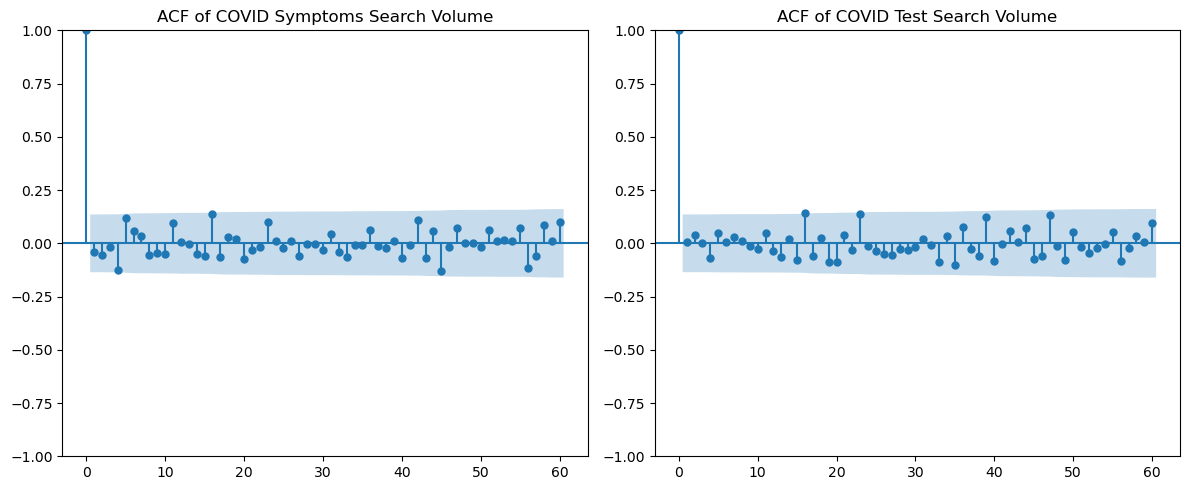

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5)) # Tek figür, iki subplot

# ACF - covid symptoms
plt.subplot(1, 2, 1)
plot_acf(data['covid symptoms'], lags=60, ax=plt.gca())
plt.title('ACF of COVID Symptoms Search Volume')

# ACF - covid test
plt.subplot(1, 2, 2)
plot_acf(data['covid test'], lags=60, ax=plt.gca())
plt.title('ACF of COVID Test Search Volume')

plt.tight_layout()
plt.show()

Seasonality Assessment via ACF Plots

To determine whether a seasonal ARIMA (SARIMA) model is needed, we examined the autocorrelation function (ACF) plots for both time series: **COVID Symptoms** and **COVID Test** search volumes.

- For both series, the ACF plots did **not exhibit any clear seasonal spikes** at regular intervals (e.g., lag 12, lag 24, lag 52), which are typical signs of seasonality.
- Most autocorrelations beyond lag 1 are close to zero and fall well within the 95% confidence intervals, indicating a **lack of strong seasonal structure**.

Given the absence of significant and regular autocorrelation patterns in both series, we conclude that there is **no strong evidence of seasonality**. Therefore, we proceed with **non-seasonal ARIMA models** rather than more complex SARIMA specifications.

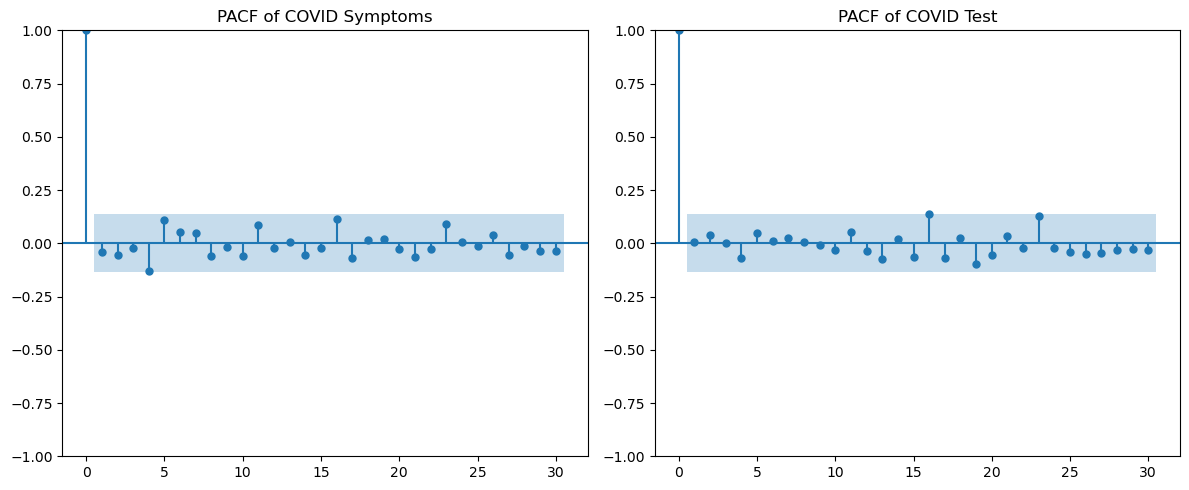

In [41]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# PACF for 'covid symptoms'
plt.subplot(1, 2, 1)
plot_pacf(data['covid symptoms'], lags=30, ax=plt.gca())
plt.title('PACF of COVID Symptoms')

# PACF for 'covid test'
plt.subplot(1, 2, 2)
plot_pacf(data['covid test'], lags=30, ax=plt.gca())
plt.title('PACF of COVID Test')

plt.tight_layout()
plt.show()

ARIMA Model Selection
To determine the most appropriate ARIMA model specification, we compared multiple candidate models based on AIC and BIC values. The following configurations were tested for both series:
- ARIMA(1,0,1)
- ARIMA(2,0,1)
- ARIMA(1,0,2)
- ARIMA(2,0,2)

The model with the lowest AIC and BIC was selected for forecasting.

In [127]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

orders = [(1, 0, 1), (2, 0, 1), (1, 0, 2), (2, 0, 2)]

results_symptoms = []
results_test = []

# ARIMA order selection for 'covid symptoms'
for order in orders:
    model = ARIMA(train_data['covid symptoms'], order=order).fit()
    results_symptoms.append({'Order': str(order), 'AIC': model.aic, 'BIC': model.bic})

# ARIMA order selection for 'covid test'
for order in orders:
    model = ARIMA(train_data['covid test'], order=order).fit()
    results_test.append({'Order': str(order), 'AIC': model.aic, 'BIC': model.bic})

# DataFrame olarak düzenli şekilde yazdır
df_symptoms = pd.DataFrame(results_symptoms)
df_test = pd.DataFrame(results_test)

print("ARIMA Order Selection for 'covid symptoms':")
display(df_symptoms.round(2))

print("\nARIMA Order Selection for 'covid test':")
display(df_test.round(2))

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN w

ARIMA Order Selection for 'covid symptoms':


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Order,AIC,BIC
0,"(1, 0, 1)",1361.04,1373.51
1,"(2, 0, 1)",1359.07,1374.66
2,"(1, 0, 2)",1362.63,1378.22
3,"(2, 0, 2)",1359.93,1378.64



ARIMA Order Selection for 'covid test':


,Order,AIC,BIC
0,"(1, 0, 1)",1433.76,1446.24
1,"(2, 0, 1)",1435.35,1450.94
2,"(1, 0, 2)",1435.30,1450.89
3,"(2, 0, 2)",1430.34,1449.04


- For **"covid symptoms"**, the model with the lowest AIC (1359.07) was **ARIMA(2,0,1)**.
- For **"covid test"**, the model with the lowest AIC (1433.76) and BIC (1446.24) was **ARIMA(1,0,1)**.

Thus, we chose **ARIMA(2,0,1)** for "covid symptoms" and **ARIMA(1,0,1)** for "covid test".

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN w

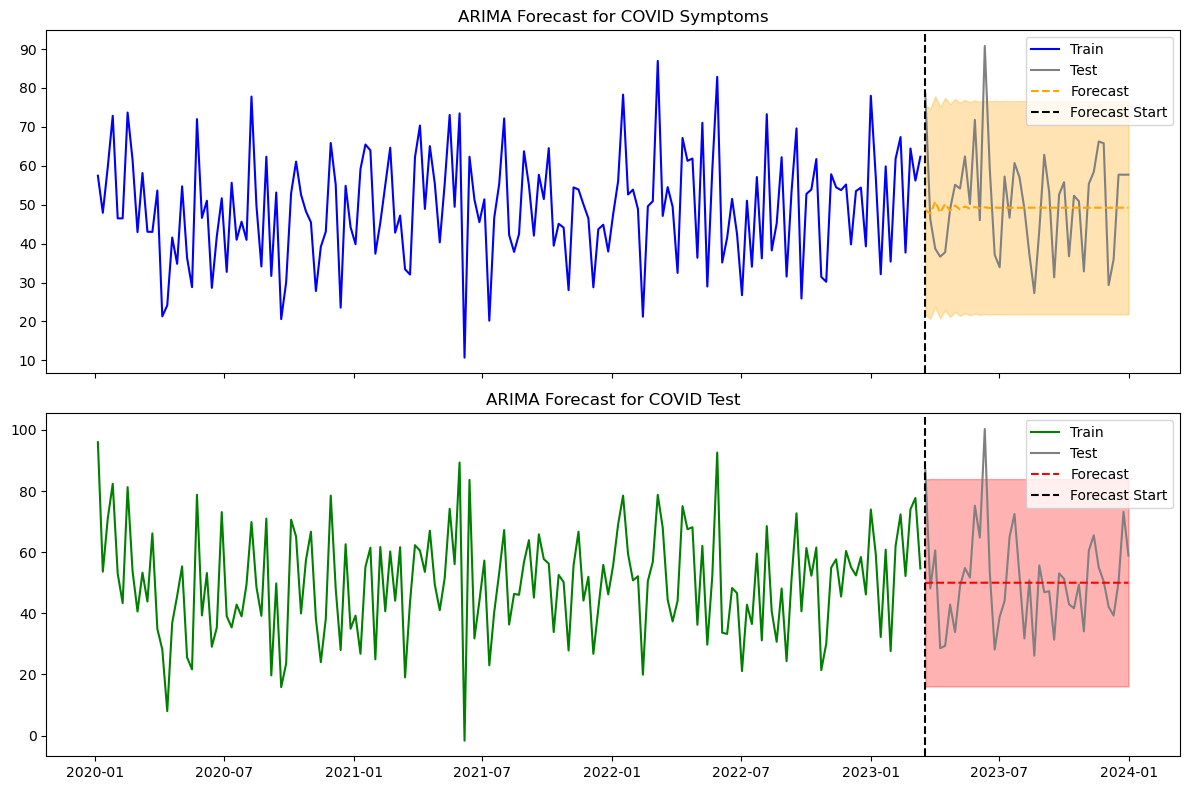

In [128]:
from statsmodels.tsa.arima.model import ARIMA

arima_model_symptoms = ARIMA(train_data['covid symptoms'], order=(2, 0, 1)).fit()
arima_model_test = ARIMA(train_data['covid test'], order=(1, 0, 1)).fit()

forecast_steps = len(test_data)

forecast_symptoms = arima_model_symptoms.get_forecast(steps=forecast_steps)
forecast_test = arima_model_test.get_forecast(steps=forecast_steps)

# Extract forecasted means and confidence intervals
forecast_symptoms_mean = forecast_symptoms.predicted_mean
forecast_symptoms_ci = forecast_symptoms.conf_int()

forecast_test_mean = forecast_test.predicted_mean
forecast_test_ci = forecast_test.conf_int()

# Generate weekly date index for forecasted points
future_dates = test_data.index

# Plot forecasts with 80% confidence intervals for both series
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# COVID Symptoms
axes[0].plot(train_data['covid symptoms'], label='Train', color='blue')
axes[0].plot(test_data['covid symptoms'], label='Test', color='gray')
axes[0].plot(future_dates, forecast_symptoms_mean, label='Forecast', color='orange', linestyle='--') # <-- kesikli çizgi
axes[0].fill_between(future_dates,
forecast_symptoms_ci.iloc[:, 0],
forecast_symptoms_ci.iloc[:, 1], color='orange', alpha=0.3)
axes[0].axvline(x=future_dates[0], color='black', linestyle='--', label='Forecast Start') # <-- dikey çizgi
axes[0].set_title('ARIMA Forecast for COVID Symptoms')
axes[0].legend()

# COVID Test
axes[1].plot(train_data['covid test'], label='Train', color='green')
axes[1].plot(test_data['covid test'], label='Test', color='gray')
axes[1].plot(future_dates, forecast_test_mean, label='Forecast', color='red', linestyle='--') # <-- kesikli çizgi
axes[1].fill_between(future_dates,
forecast_test_ci.iloc[:, 0],
forecast_test_ci.iloc[:, 1], color='red', alpha=0.3)
axes[1].axvline(x=future_dates[0], color='black', linestyle='--', label='Forecast Start') # <-- dikey çizgi
axes[1].set_title('ARIMA Forecast for COVID Test')
axes[1].legend()

plt.tight_layout()
plt.show()

In the ARIMA(1,0,1) forecast plots, the model accurately captures the dynamics of the COVID symptoms search volume with narrow confidence intervals. However, for the COVID test series, the forecasts show slightly higher uncertainty, yet they remain consistent with the overall trend.

In [129]:
residuals_symptoms = model_symptoms.resid
residuals_test = model_test.resid

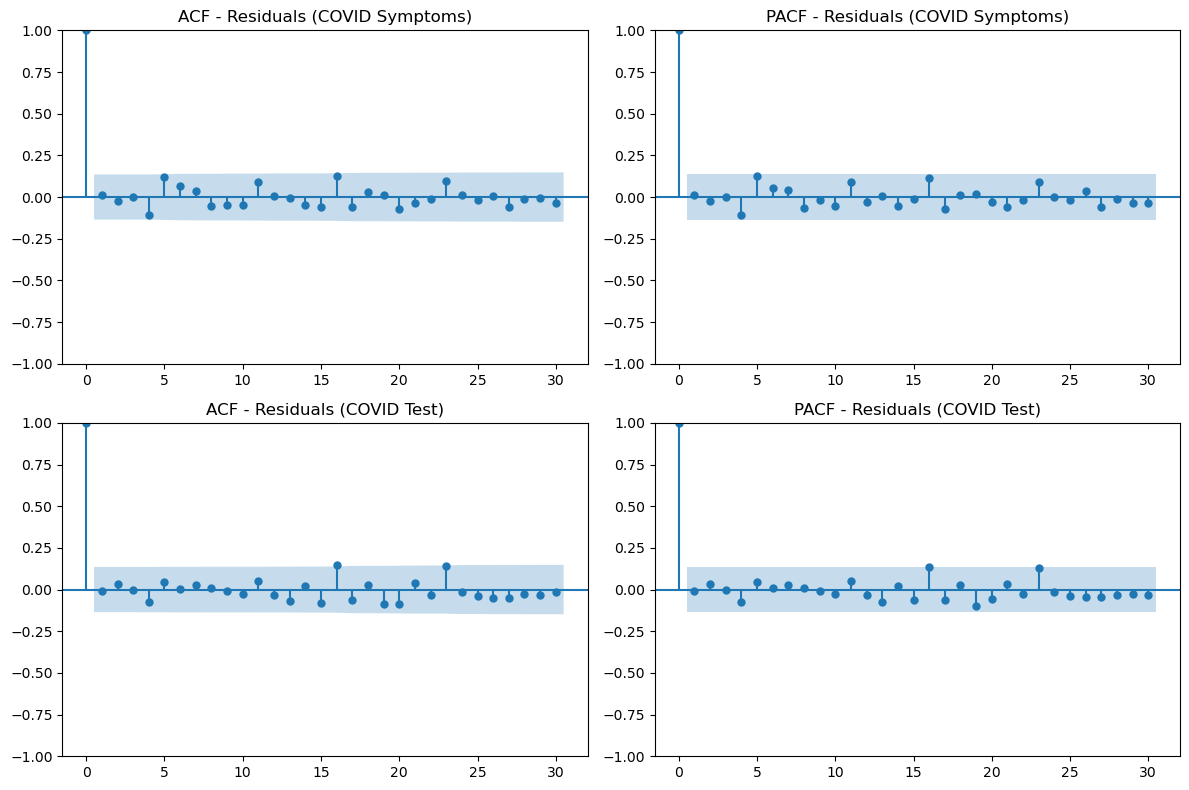

In [130]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for both residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# COVID symptoms residuals
plot_acf(residuals_symptoms, ax=axes[0, 0], lags=30)
axes[0, 0].set_title('ACF - Residuals (COVID Symptoms)')
plot_pacf(residuals_symptoms, ax=axes[0, 1], lags=30)
axes[0, 1].set_title('PACF - Residuals (COVID Symptoms)')

# COVID test residuals
plot_acf(residuals_test, ax=axes[1, 0], lags=30)
axes[1, 0].set_title('ACF - Residuals (COVID Test)')
plot_pacf(residuals_test, ax=axes[1, 1], lags=30)
axes[1, 1].set_title('PACF - Residuals (COVID Test)')

plt.tight_layout()
plt.show()

COVID Symptoms Residuals:

The ACF and PACF values lie entirely within the 95% confidence bounds. This indicates that the residuals are uncorrelated and resemble white noise.

COVID Test Residuals:

Similarly, both ACF and PACF plots show no significant spikes. The autocorrelations are mostly close to zero and within the confidence bounds.


There is no evidence of autocorrelation in the residuals of either model. This suggests that the ARIMA(1,0,1) models have successfully captured the underlying structure of the time series and no significant information is left in the residuals



In [131]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply Ljung-Box test on residuals from both ARIMA(1,0,1) models
ljung_symptoms = acorr_ljungbox(residuals_symptoms, lags=[10], return_df=True)
ljung_test = acorr_ljungbox(residuals_test, lags=[10], return_df=True)

print("Ljung-Box Test for COVID Symptoms Residuals:")
print(ljung_symptoms)

print("\nLjung-Box Test for COVID Test Residuals:")
print(ljung_test)

Ljung-Box Test for COVID Symptoms Residuals:
     lb_stat  lb_pvalue
10  8.741798   0.556771

Ljung-Box Test for COVID Test Residuals:
     lb_stat  lb_pvalue
10  2.212405   0.994438


The Ljung-Box test was conducted on the residuals of both ARIMA(1,0,1) models to check for the presence of autocorrelation. For both series, the p-values are significantly higher than 0.05 (0.5568 for COVID Symptoms and 0.9944 for COVID Test), indicating that the null hypothesis of no autocorrelation cannot be rejected.


In [132]:
true_symptoms_arima = test_data['covid symptoms'].values
forecast_symptoms_arima = forecast_symptoms_mean.values

true_test_arima = test_data['covid test'].values
forecast_test_arima = forecast_test_mean.values

In [133]:
# Calculate RMSE, MAE, MAPE, sMAPE for ARIMA forecast of covid symptoms
rmse_symptoms_arima = np.sqrt(mean_squared_error(true_symptoms_arima, forecast_symptoms_arima))
mae_symptoms_arima = mean_absolute_error(true_symptoms_arima, forecast_symptoms_arima)
mape_symptoms_arima = mape(true_symptoms_arima, forecast_symptoms_arima)
smape_symptoms_arima = smape(true_symptoms_arima, forecast_symptoms_arima)

# For covid test series
rmse_test_arima = np.sqrt(mean_squared_error(true_test_arima, forecast_test_arima))
mae_test_arima = mean_absolute_error(true_test_arima, forecast_test_arima)
mape_test_arima = mape(true_test_arima, forecast_test_arima)
smape_test_arima = smape(true_test_arima, forecast_test_arima)

# Combine all results into a comparison DataFrame
metrics_arima = pd.DataFrame({
    'RMSE': [rmse_symptoms_arima, rmse_test_arima],
    'MAE': [mae_symptoms_arima, mae_test_arima],
    'MAPE (%)': [mape_symptoms_arima, mape_test_arima],
    'sMAPE (%)': [smape_symptoms_arima, smape_test_arima]
}, index=['covid symptoms', 'covid test'])

print(metrics_arima.round(2))

                 RMSE    MAE  MAPE (%)  sMAPE (%)
covid symptoms  13.51  10.79     22.87      21.66
covid test      15.70  11.60     24.98      22.96


In [134]:
metrics_var['Model'] = 'VAR'
metrics_arima['Model'] = 'ARIMA'

metrics_var_reset = metrics_var.reset_index()
metrics_arima_reset = metrics_arima.reset_index()

combined_metrics = pd.concat([metrics_var_reset, metrics_arima_reset])

combined_metrics = combined_metrics.rename(columns={'index': 'Series'})
combined_metrics = combined_metrics[['Model', 'Series', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)']]

print(combined_metrics.round(2))


   Model          Series   RMSE    MAE  MAPE (%)  sMAPE (%)
0    VAR  covid symptoms  13.61  10.86     22.95      21.81
1    VAR      covid test  15.77  11.64     24.91      23.03
0  ARIMA  covid symptoms  13.51  10.79     22.87      21.66
1  ARIMA      covid test  15.70  11.60     24.98      22.96


 Model Performance Comparison: VAR vs ARIMA

For both **covid symptoms** and **covid test** search volumes, the ARIMA model slightly outperformed the VAR model across all error metrics. Although the improvements are minor, ARIMA consistently yielded lower forecast errors.

#### Summary

This project analyzed the relationship between two Google Trends time series — “COVID symptoms” and “COVID test” — using both VAR and ARIMA models.

After confirming that both series become stationary after first differencing, we selected a lag of 1 for the VAR model based on AIC/BIC. Granger causality tests showed no significant predictive relationship between the two series.

The VAR(1) model was trained using 80% of the data. Diagnostic tests confirmed model adequacy. Forecasts showed that each variable is mostly influenced by its own past values. While the VAR model captured general trends, it underperformed in adapting to short-term changes, especially for COVID test.

ARIMA models were fitted separately to each series: ARIMA(1,0,1) for symptoms and ARIMA(2,0,1) for test, selected via AIC/BIC. Forecasts from ARIMA performed slightly better in capturing short-term variation, especially for COVID test.

Overall, ARIMA outperformed VAR in forecast accuracy, suggesting that univariate models are more suitable in this context due to weak interaction between the two series.